In [1]:
using Images
using PyPlot

In [2]:
# Create a gaussian filter
function makegaussianfilter(size::Array{Int,2},sigma::Float64)
    # compute width of filter
    wx, wy = (size.-1) ./ 2
    # make two 1d filters
    gx = reshape([exp(- x^2 / (2 * sigma^2)) for x in -wx:wx], (size[1],1))
    gy = reshape([exp(- y^2 / (2 * sigma^2)) for y in -wy:wy], (1,size[2]))
    # normalize
    gx = gx / sum(gx)
    gy = gy / sum(gy)
    # outer product
    f = gx * gy
    return f::Array{Float64,2}
end

makegaussianfilter([5 5], 1.)

5×5 Array{Float64,2}:
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062 
 0.0219382   0.0983203  0.162103   0.0983203  0.0219382 
 0.0133062   0.0596343  0.0983203  0.0596343  0.0133062 
 0.00296902  0.0133062  0.0219382  0.0133062  0.00296902

In [3]:
# Create a binomial filter
function makebinomialfilter(size::Array{Int,2})
    # binomial filter in x direction
    bx = reshape([binomial(size[1]-1, k) for k in 0:size[1]-1], (size[1],1))
    bx = bx / sum(bx)
    # binomial filter in y direction
    by = reshape([binomial(size[2]-1, k) for k in 0:size[2]-1], (1, size[2]))
    by = by / sum(by)
    # outer product
    f = bx * by
    return f::Array{Float64,2}
end

makebinomialfilter([5 5])

5×5 Array{Float64,2}:
 0.00390625  0.015625  0.0234375  0.015625  0.00390625
 0.015625    0.0625    0.09375    0.0625    0.015625  
 0.0234375   0.09375   0.140625   0.09375   0.0234375 
 0.015625    0.0625    0.09375    0.0625    0.015625  
 0.00390625  0.015625  0.0234375  0.015625  0.00390625

In [4]:
# Downsample an image by a factor of 2
function downsample2(A::Array{Float64,2})
    # skip every other row
    D = A[1:2:end, 1:2:end]
    return D::Array{Float64,2}
end

# Upsample an image by a factor of 2
function upsample2(A::Array{Float64,2},fsize::Array{Int,2})
    U = zeros(size(A) .* 2)
    # fill every second entry
    U[1:2:end, 1:2:end] = A
    # filter with a binomial filter of given size
    U = 4 * imfilter(U, centered(makebinomialfilter(fsize)), "symmetric")
  return U::Array{Float64,2}
end

upsample2 (generic function with 1 method)

In [9]:
# Build a gaussian pyramid from an image.
# The output array should contain the pyramid levels in decreasing sizes.
function makegaussianpyramid(im::Array{Float32,2},nlevels::Int,fsize::Array{Int,2},sigma::Float64)
    # initialize array of arrays
    G = Array{Array{Float64,2},1}(undef,nlevels)
    # the first element of the pyramid is the original image
    G[1] = Float64.(im)
    # for the remaining nlevels-1 elements
    for i in 2:nlevels
        # filter with a gaussian
        fim = imfilter(G[i-1], makegaussianfilter(fsize, sigma), "symmetric")
        # downsample by a factor of two
        G[i] = downsample2(fim)
    end
    return G::Array{Array{Float64,2},1}
end

im = PyPlot.imread("../data-julia/a2p1.png")
P = makegaussianpyramid(im, 4, [5 5], 1.)

┌ Warning: assuming that the origin is at the center of the kernel; to avoid this warning, call `centered(kernel)` or use an OffsetArray
│   caller = kernelshift at imfilter.jl:1509 [inlined]
└ @ Core /home/dominik/.julia/packages/ImageFiltering/bMda8/src/imfilter.jl:1509
┌ Warning: assuming that the origin is at the center of the kernel; to avoid this warning, call `centered(kernel)` or use an OffsetArray
│   caller = kernelshift at imfilter.jl:1509 [inlined]
└ @ Core /home/dominik/.julia/packages/ImageFiltering/bMda8/src/imfilter.jl:1509


4-element Array{Array{Float64,2},1}:
 [0.45098 0.45098 … 0.670588 0.662745; 0.45098 0.45098 … 0.662745 0.662745; … ; 0.537255 0.427451 … 0.803922 0.756863; 0.427451 0.47451 … 0.772549 0.772549]     
 [0.450996 0.426506 … 0.685631 0.670779; 0.457223 0.423832 … 0.6813 0.670369; … ; 0.492634 0.411801 … 0.767265 0.770471; 0.484218 0.42361 … 0.776802 0.779286]   
 [0.441819 0.418018 … 0.689224 0.680486; 0.433157 0.414076 … 0.686793 0.678553; … ; 0.498551 0.549961 … 0.695232 0.732114; 0.47202 0.496538 … 0.762269 0.763155] 
 [0.430309 0.413192 … 0.671068 0.686911; 0.428335 0.419147 … 0.668263 0.676003; … ; 0.347677 0.557848 … 0.610382 0.659511; 0.470471 0.580523 … 0.691511 0.708412]

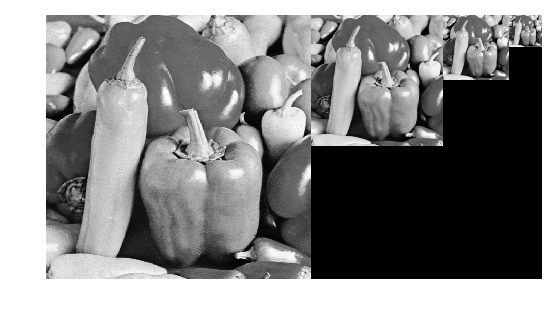

In [10]:
# Display a given image pyramid (laplacian or gaussian)
function displaypyramid(P::Array{Array{Float64,2},1})
    # initialized a empty
    filled = Array{Array{Float64,2},1}(undef,size(P))
    for i in 1:size(P)[1]
        # current pyramid image
        pimg = copy(P[i])
        # normalize the current level -> (0,1)
        pimg = (pimg .- minimum(pimg)) ./ (maximum(pimg) - minimum(pimg))
        # fill the rest of the image with zeros (black)
        A = zeros(size(P[1],1), size(pimg,2))
        A[1:size(pimg,1),1:size(pimg,2)] = pimg
        filled[i] = A
    end
    # concatenate into one image and display that
    img = hcat(filled...)
    PyPlot.imshow(img, cmap="gray")
    PyPlot.axis("off")
    return nothing
end
displaypyramid(P)

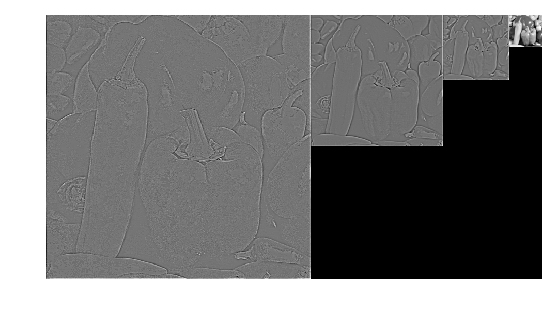

In [11]:
# Build a laplacian pyramid from a gaussian pyramid.
# The output array should contain the pyramid levels in decreasing sizes.
function makelaplacianpyramid(G::Array{Array{Float64,2},1},nlevels::Int,fsize::Array{Int,2})
    # L_n = G_n
    L = Array{Array{Float64,2},1}(undef,size(G))
    L[nlevels] = copy(G[nlevels])
    # for level n-1 down to level 1
    for i in nlevels-1:-1:1
        L[i] = G[i] .- upsample2(G[i+1], fsize)
    end
    return L::Array{Array{Float64,2},1}
end
L = makelaplacianpyramid(P, 4, [5 5])
displaypyramid(L)

In [22]:
collect(1:0)

0-element Array{Int64,1}

In [62]:
# Amplify frequencies of the first two layers of the laplacian pyramid
function amplifyhighfreq2(L::Array{Array{Float64,2},1})
    A = copy(L)
    A[1] = A[1] .* 1.2
    A[2] = A[2] .* 2.5
    return A::Array{Array{Float64,2},1}
end

# Reconstruct an image from the laplacian pyramid
function reconstructlaplacianpyramid(L::Array{Array{Float64,2},1},fsize::Array{Int,2})
    R = copy(L)
    for i in length(L)-1:-1:1
        R[i] = R[i] .+ upsample2(R[i+1], fsize)
    end
    im = R[1]
    return im::Array{Float64,2}
end


# Problem 1: Image Pyramids and Image Sharpening

function problem1()
  # parameters
  fsize = [5 5]
  sigma = 1.4
  nlevels = 6

  # load image
  im = PyPlot.imread("../data-julia/a2p1.png")

  # create gaussian pyramid
  G = makegaussianpyramid(im,nlevels,fsize,sigma)

  # display gaussianpyramid
  displaypyramid(G)
  title("Gaussian Pyramid")

  # create laplacian pyramid
  L = makelaplacianpyramid(G,nlevels,fsize)

  # dispaly laplacian pyramid
  displaypyramid(L)
  title("Laplacian Pyramid")

  # amplify finest 2 subands
  L_amp = amplifyhighfreq2(L)

  # reconstruct image from laplacian pyramid
  im_rec = reconstructlaplacianpyramid(L_amp,fsize)

  # display original and reconstructed image
  figure()
  subplot(131)
  imshow(im,"gray",interpolation="none")
  axis("off")
  title("Original Image")
  subplot(132)
  imshow(im_rec,"gray",interpolation="none")
  axis("off")
  title("Reconstructed Image")
  subplot(133)
  imshow(im-im_rec,"gray",interpolation="none")
  axis("off")
  title("Difference")
  gcf()

  return
end

problem1 (generic function with 1 method)

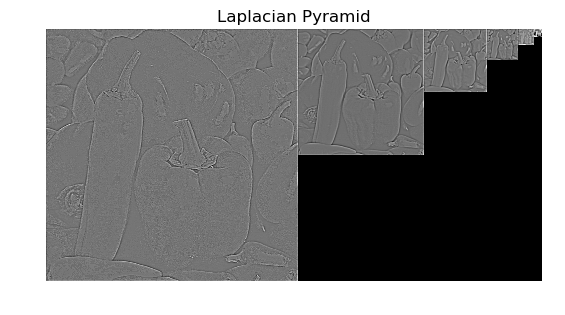

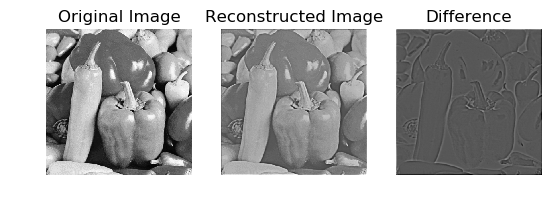

In [63]:
problem1()